# Build a Collaborative Filtering Recommendation System in NumPy
***
<img src="collaborative_filtering.png" width="22%"/>

_Recommender systems are machine learning systems that are responsible for predicting user preferences. They represent a powerful method for enabling users to filter through large information and product spaces._

## What you'll do

In this tutorial, we will use NumPy to build a model-based recommendation system. In other words, we will extract some information from the dataset, and use that as a "model" to make recommendations without having to use the complete dataset every time. This approach offers the benefits of both speed and scalability.

## What you'll learn

- You'll learn to load data from a comma separated values (\*.csv) file
- You'll use ordinary least squares to do linear regression and predict exponential growth
- You'll compare exponential growth constants between models
- You'll share your analysis as NumPy zipped files (\*.npz) 
- You'll share your analysis as a \*.csv file
- You'll assess the amazing progress semiconductor manufacturers have made in the last five decades

## What you'll need

First, you need to import the necessary libraries:

* NumPy
* Matplotlib
* Tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Loading the MovieLens 100K dataset to our workspace

The dataset used in this tutorial is stored as a `*.npy` file. A `*.npy` file is a NumPy array file that contains an array saved in the NumPy file format. A `*.npy` file stores all the information required to reconstruct an array, including any `dtype` and `shape` information.

The dataset used in this tutorial is a subset of the [MovieLens dataset](https://grouplens.org/datasets/movielens/100k/). It consists of 90,570 ratings (1-5) from 943 users on 1680 movies. 

Note that each user has rated at least 20 movies. This indicates that there will be a lot of sparsity in the data - this is precisely why we will create a model-based Collaborative Filtering system. 

A model-based Collaborative Filtering system is a latent factor model that can handle sparsity. Consider a sparse rating matrix of which the elements are ratings given by a user $j$ to a movie $i$. The rating matrix is modeled by a matrix product of $X$ (item-feature matrix) and $\theta$ (user-feature matrix). Each rating given by user $j$ to movie $i$ is as follows:
$$rating(i, j) = \theta^{j^T} x^i$$
The matrix form is as follows:
$$rating = X * \theta^T$$

Your goal is to help estimate the missing ratings (values of 0 in the dataset).

First, let us begin by simply loading the dataset using the `numpy.load` function. 

In [5]:
ratings = np.load('ratings.npy')

In [6]:
ratings

array([[5., 4., 0., ..., 5., 0., 0.],
       [3., 0., 0., ..., 0., 0., 5.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
ratings.shape

(1680, 943)

The `shape` of the data tells us that there are 943 users and 1680 movies.

A dataframe representation of the matrix is shown below:

||User 1|User 2|User 3|User 4|User 5|User 6|User 7|User 8|User 9|User 10|...|User 934|User 935|User 936|User 937|User 938|User 939|User 940|User 941|User 942|User 943|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|**Movie 1**|5|4|0|0|0|4|0|0|0|4|...|2|3|4|0|4|0|0|5|0|0|0|
|**Movie 2**|3|0|0|0|0|0|0|0|0|0|...|4|0|0|0|0|0|0|0|0|5|0|
|**Movie 3**|4|0|0|0|0|0|0|0|0|0|...|0|0|4|0|0|0|0|0|0|0|0|
|**Movie 4**|3|0|0|0|0|0|5|0|0|4|...|5|0|0|0|0|0|2|0|0|0|0|
|**Movie 5**|3|0|0|0|0|0|0|0|0|0|...|0|0|0|0|0|0|0|0|0|0|0|
|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|
|**Movie 1676**|0|0|0|0|0|0|0|0|0|0|...|0|0|0|0|0|0|0|0|0|0|0|
|**Movie 1677**|0|0|0|0|0|0|0|0|0|0|...|0|0|0|0|0|0|0|0|0|0|0|
|**Movie 1678**|0|0|0|0|0|0|0|0|0|0|...|0|0|0|0|0|0|0|0|0|0|0|
|**Movie 1679**|0|0|0|0|0|0|0|0|0|0|...|0|0|0|0|0|0|0|0|0|0|0|
|**Movie 1680**|0|0|0|0|0|0|0|0|0|0|...|0|0|0|0|0|0|0|0|0|0|0|

In NumPy, all logical operators are applied _element-wise_. Let's further examine the sparsity of the matrix.

In [8]:
R = ratings != 0
R

array([[ True,  True, False, ...,  True, False, False],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

To cast an array to a particular dtype, use the `astype` method.

In [9]:
R = R.astype(float)
R

array([[1., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let's leverage the `numpy.count_nonzero` function to tally the number of nonzero elements.

In [21]:
np.count_nonzero(R)

90570

To check the total size of an array, simply use the `*.size` property.

To get the sum of all the values in an array, simply use the `sum` method.

In [11]:
(R.size - R.sum()) / R.size

0.9428306317224663

Over 94% of our dataset is empty!

Finally, let's try plotting the sparsity pattern of the matrix using the `ax.spy` function from `matplotlib`.

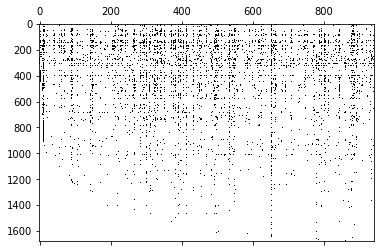

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

# display the matrix
ax.spy(R)

ax.set_aspect('auto')

***

## Computing the regularized loss

In order to find the best model, a common method in machine learning is to define a loss function that describes how well the model fits the data.

In the case of polynomials, we can define a loss function, $J$, as follows:
$$J = \frac{1}{2} \Bigg[ \sum_{i=1}^{n_{items}} \sum_{j:r(i,j)=1} (\theta^{(j)^{T}} x^{(i)} - y^{(i,j)})^2 \Bigg]$$

Note that the rating matrix is modeled by a matrix product of $X$ (item-feature matrix) and $\theta$ (user-feature matrix).

Next, penalize the loss function by adding a regularization parameter. The regularization parameter reduces overfitting, which reduces the variance of your estimated regression parameters. In our case, we can use the square sum of the polynomial parameters.

$$J = \frac{1}{2} \Bigg[ \sum_{i=1}^{n_{items}} \sum_{j:r(i,j)=1} (\theta^{(j)^{T}} x^{(i)} - y^{(i,j)})^2 \Bigg] + \frac{\lambda}{2} \sum_{i=1}^{n_{items}} \sum_{k=1}^{n} (x_k^{(i)})^2 + \frac{\lambda}{2} \sum_{i=1}^{n_{users}} \sum_{k=1}^{n} (\theta_k^{(j)})^2$$

The value of the $\lambda$ can be adjusted as needed to calibrate the level of penalization on complex models. For very large $\lambda$, models with high complexity are ruled out. Likewise, for very small $\lambda$, models with high training errors are ruled out. Thus, the optimal solution lies somewhere in the middle.

The goal of our model then is to minimize the following regularized loss function:
$$J(\theta^{(1)} \theta^{(2)} \dots \theta^{(j)} \dots \theta^{(n_{users})}, x^{(1)} x^{(2)} \dots x^{(i)} \dots x^{(n_{items})}) = \frac{1}{2} \Bigg[ \sum_{i=1}^{n_{items}} \sum_{j:r(i,j)=1} (\theta^{(j)^{T}} x^{(i)} - y^{(i,j)})^2 \Bigg] + \frac{\lambda}{2} \sum_{i=1}^{n_{items}} \sum_{k=1}^{n} (x_k^{(i)})^2 + \frac{\lambda}{2} \sum_{i=1}^{n_{users}} \sum_{k=1}^{n} (\theta_k^{(j)})^2$$

NumPy makes implementating our regularized loss function fairly straightforward!

***

Let's take a look at the input arguments of the loss function.

* **params**, _np.ndarray_, Random weights
* **Y**, _np.ndarray_, User ratings
* **R**, _np.ndarray_, User ratings are replaced with 1
* **num_users**, _int_, Number of users
* **num_movies**, _int_, Number of movies
* **num_features**, _int_, Number of features
* **lambd**, _float_, Regularization parameter

In [86]:
def loss(
    params: np.ndarray,
    Y: np.ndarray,
    R: np.ndarray,
    num_users: int,
    num_movies: int,
    num_features: int,
    lambd: float,
) -> float:
    
    # unwrap params into X and theta
    X = params[: num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # make prediction and compute loss
    pred =  np.dot(X, theta.T)
    loss = (pred - Y)
    
    # compute the loss
    J = np.sum((np.square(loss * R))) / 2
    
    # compute the regularization
    r_X =  lambd / 2 * np.sum(np.square(theta))
    r_Theta = lambd / 2 * np.sum(np.square(X))
    
    # add to original loss
    J = J + r_X + r_Theta
    
    return J

$$\sum_{i:r(i, j)=1}(\theta(j)^T x^{(i)} - y^{(i, j)} x_k^{(i)} + \lambda \theta_k^{(j)}$$

In [87]:
def gradient(params, Y, R, num_users, num_movies, num_features, lambd):    
    # unwrap params into X and theta
    X = params[: num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)

    # make prediction and compute loss
    pred =  np.dot(X, theta.T)
    loss = (pred - Y)
        
    # compute gradient with regularization
    X_grad = np.dot(loss * R, theta) + lambd * X
    theta_grad = np.dot((loss * R).T, X) + lambd * Theta

    grad = np.squeeze(np.concatenate((X_grad.reshape([num_movies * num_features, 1], order = "f"),
                      theta_grad.reshape([num_users * num_features, 1], order = "f"))))

    return grad

In [88]:
def optimize(params, Y, r, n_users, n_items, n_features, lambd, step, maxrun):
    loss = []
    for i in tqdm.trange(maxrun):
        params_prime = params
        J = loss(params_prime, Y, r, n_users, n_items, n_features, lambd)
        grad = gradient(params_prime, Y, r, n_users, n_items, n_features, lambd)
        params = params_prime - step * grad
        # append loss value on each iteration to loss list so we can plot
        loss.append(J)

    return params, loss

In [89]:
n_items, n_users = ratings.shape
n_features = 1

In [90]:
# Initialization
X = np.random.normal(loc = 0.0, scale = 1.0, size = (n_items, n_features))
Theta = np.random.normal(loc = 0.0, scale = 1.0, size = (n_users,n_features))

init_params = np.concatenate((X.reshape(n_items * n_features, 1, order = "F"),
                             Theta.reshape(n_users * n_features, 1, order = "F")))
init_params = np.squeeze(init_params)

In [93]:
# Optimization
lamba = 0.1
maxrun = 4000
step = 0.00001
params, loss = optimize(init_params, ratings, R, n_users, n_items, n_features, lamba, step, maxrun)

100%|██████████| 10000/10000 [04:28<00:00, 37.25it/s]


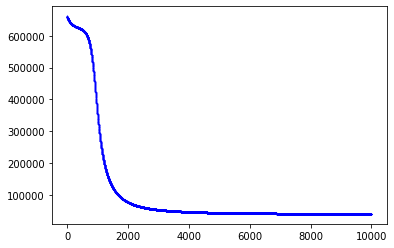

In [94]:
# loss
plt.plot(loss,"b.",markersize=1,label="loss") # note: this is 0-based
plt.show()

In [95]:
# Extract X and Theta from params vector
X = params[0:(n_items * n_features)]
Theta = params[(n_items * n_features):len(params)]

In [96]:
X.shape, Theta.shape

((1680,), (943,))

In [97]:
X.reshape(n_items, n_features)

array([[-2.00434982],
       [-1.69214737],
       [-1.60053077],
       ...,
       [-0.52659874],
       [-0.7802559 ],
       [-0.51879928]])

In [98]:
X = X.reshape(n_items, n_features, order = "F")
Theta = Theta.reshape(n_users, n_features, order = "F")

In [99]:
X.shape, Theta.shape

((1680, 1), (943, 1))

In [100]:
X

array([[-2.00434982],
       [-1.69214737],
       [-1.60053077],
       ...,
       [-0.52659874],
       [-0.7802559 ],
       [-0.51879928]])

In [101]:
pred = np.dot(X, Theta.T)

In [102]:
pred.round()

array([[4., 4., 3., ..., 4., 4., 4.],
       [3., 3., 3., ..., 3., 4., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 1., ..., 2., 2., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## References

1. [F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.](http://dx.doi.org/10.1145/2827872)